##  Giới thiệu 

Gradient Booting Machine (viết tắt là GBM, hoặc có khi chỉ nói ngắn hơn là Gradient Booting) là một cách tiếp cận của Machine Learning cho cả bài toán hồi quy và phân loại. Chi tiết hơn về mô hình  này bạn đọc có thể tham khảo [tại đây](https://en.wikipedia.org/wiki/Gradient_boosting). 

Trong bài này chúng ta sẽ sử dụng bộ dữ liệu có tên **hmeq.csv** từ cuốn sách [Credit Risk Analytics: Measurement Techniques, Applications, and Examples in SAS](http://www.creditriskanalytics.net/datasets-private.html). Đây là bộ dữ liệu được sử dụng nhiều lần trong cuốn sách này cho một số mô hình phân loại. 

Mô tả về các biến (cũng như link download bộ số liệu) đã có ở link trên. Mục tiêu của chúng ta là dựa trên các thông tin về khách hàng xin cấp tín dụng (nghề nghiệp, mục đích vay, số tiền vay, có tiền án hay chưa..) để xây dựng một mô hình phân loại hồ sơ làm cơ sở cấp tín dụng cho khách hàng. 

Với các bài toán phân loại như vừa trình  bày, Logistic thường là mô hình  được nghĩ đến đầu tiên. Tuy vậy chất lượng phân loại của  mô hình này là chưa tốt. 

Sử dụng mô hình GBM kết quả phân loại của  mô hình đạt mức chính xác cao hơn  nhiều so với Logistic đối với bộ dữ liệu hmeq.csv. Cụ thể chất lượng phân loại mô hình GBM đối với bộ dữ liệu test: (1) Accuracy là 94.43%, (2) tỉ lệ xếp nhầm hồ sơ xấu thành hồ sơ tốt (đây mới là quan trọng) ở mức thấp 17.65%, (3) AUC = 0.97 (mức rất cao theo [các tiêu chuẩn đánh giá chất lượng mô hình phân loại](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3755824/), và (4) Gini = 0.94.

Mặt khác sử dụng 30 mẫu khác nhau để kiểm định lại mô hình đã có thì tỉ lệ chính xác trung bình là 98.06% với độ lệch chuẩn rất bé 0.2%. 

Post này được trình bày theo thứ tự như sau. Trước hết là thực hiện tiền xử lí số liệu (xử lí dữ liệu trống, dán lại nhãn cho các quan sát, được giải thích chi tiết [ở đây](https://github.com/chidungkr/Data_Wrangling_pandas_DeepLearning/blob/master/chapter2_pandas.ipynb)). Kế đến mô hình GBM không tinh chỉnh được thực hiện trước với mục đính thăm dò và cuối cùng một mô hình tinh chỉnh cuối cùng được lựa chọn được lựa chọn. 

Ngôn ngữ sử dụng là Python với gói h20. Mặc dù gói này có thể sử dụng trong R nhưng ở đây Python được lựa chọn vì những thế  mạnh của nó khi thực hiện các thuật toán Machine Learning và Deep Learning. 




### Tiền xử lí số liệu

Dưới đây là codes cho tiền xử lí số liệu (được làm gọn lại mà không giải thích gì): 


In [258]:
# Đọc vào bộ dữ liệu này với tên credit và thực hiện tiền xử lí số liệu: 
import pandas as pd
credit = pd.read_csv("F:/Python_project/python_mini_project/hmeq.csv")

credit = credit.assign(MORTDUE = credit["MORTDUE"].fillna(credit["MORTDUE"].mean()),
                       VALUE = credit["VALUE"].fillna(credit["VALUE"].mean()), 
                       DEBTINC = credit["DEBTINC"].fillna(credit["DEBTINC"].mean()), 
                       JOB = credit["JOB"].fillna("Other"), 
                       REASON = credit["REASON"].fillna("Unknown"))

In [259]:
# Dán lại nhãn cho BAD và giữ lại bản dữ liệu gốc credit: 
df = credit.dropna(how = "any", axis = 0)
df2 = df.assign(BAD = df["BAD"].map(lambda x: "B" if x == 1 else "G"))
df2.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,B,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,33.779915
1,B,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,33.779915
2,B,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,33.779915
4,G,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,33.779915
5,B,1700,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614


### GBM mặc định (default)

Dưới đây thực hiện GBM mặc định trong đó 80% dữ liệu được sử dụng để dựng mô hình, 20% còn lại được sử dụng để đánh giá chất lượng của  mô hình. Mặt khác để đánh giá chi tiết hơn chất lượng của mô hình cross - validation với k = 5 được sử dụng: 

In [260]:
# Load gói h2o: 
import h2o

# Chỉ định 2 nhân của bộ vi xử lí, sử dụng 6 Gi RAM: 
h2o.init(nthreads = 2, max_mem_size = 6)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.131-b11, mixed mode)
  Starting server from C:\Users\win10ls\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\win10ls\AppData\Local\Temp\tmpcwwfhw_i
  JVM stdout: C:\Users\win10ls\AppData\Local\Temp\tmpcwwfhw_i\h2o_win10ls_started_from_python.out
  JVM stderr: C:\Users\win10ls\AppData\Local\Temp\tmpcwwfhw_i\h2o_win10ls_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster version:,3.16.0.2
H2O cluster version age:,"14 days, 5 hours and 46 minutes"
H2O cluster name:,H2O_from_python_win10ls_cljh79
H2O cluster total nodes:,1
H2O cluster free memory:,5.333 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [261]:
# Chuyển hóa về object của h2o: 
df = h2o.H2OFrame(df2)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [262]:
# Chỉ thị biến Input và Output: 
response = "BAD"
predictors = df.names
predictors.remove("BAD")

In [263]:
# Phân chia dữ liệu: 
train, test = df.split_frame(ratios = [0.8], seed = 1234)

In [264]:
# Thực hiện GBM mặc định đồng thời thực  hiện  cross - validation với k = 5: 
from h2o.estimators.gbm import H2OGradientBoostingEstimator
cv_gbm = H2OGradientBoostingEstimator(nfolds = 5, seed = 29)
cv_gbm.train(x = predictors, y = response, training_frame = train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [265]:
# Đánh giá qua chất lượng của mô hình trên bộ dữ liệu train: 
cv_summary = cv_gbm.cross_validation_metrics_summary().as_data_frame()
cv_summary

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.9126177,0.006552664,0.89673203,0.9088639,0.91699094,0.916558,0.92394364
1,auc,0.9365273,0.010126648,0.9204472,0.94136924,0.93870157,0.9223821,0.95973635
2,err,0.087382294,0.006552664,0.103267975,0.09113608,0.08300908,0.08344198,0.07605634
3,err_count,66.8,6.0564017,79.0,73.0,64.0,64.0,54.0
4,f0point5,0.9329659,0.0061356486,0.91885823,0.93506086,0.92802453,0.9430101,0.9398756
5,f1,0.94598395,0.0043874066,0.9355102,0.9425649,0.9498433,0.9492868,0.95271456
6,f2,0.9594473,0.0060195317,0.95277685,0.95019037,0.9727127,0.9556477,0.96590906
7,lift_top_group,1.2342124,0.056524605,1.2878788,1.277512,1.2577487,1.0755209,1.2724015
8,logloss,0.24091102,0.014306171,0.27356184,0.24414773,0.23189491,0.24372014,0.21123052
9,max_per_class_error,0.29888934,0.030056799,0.33918127,0.25862068,0.3607595,0.27272728,0.2631579


Con số 0.9126177 ở dòng  accuracy chính là Accuracy trung bình của 5 mô hình con (chính là trung bình của 0.89673203 cho đến 0.92394364). Các tiêu chí đánh giá chất lượng khác của mô hình cũng được hiểu tương tự. 

Căn cứ theo các tiêu chuẩn thống kê thì chất lượng của mô hình trên bộ dữ liệu train là khá tốt. Nhưng đây không phải là điều  chúng ta quan tâm nhiều vì thứ chúng ta muốn là khả năng phân loại và chất lượng của mô hình trên bộ dữ liệu tương lai, trên bộ dữ liệu test. 

Dưới đây là các thông tin về khả năng dự báo của  mô hình trên bộ dữ liệu test:

In [266]:
# Sử dụng dữ liệu test để đánh giá mô hình: 
perf_cv_test = cv_gbm.model_performance(test)

In [267]:
# AUC trên bộ dữ liệu test: 
perf_cv_test.auc()

0.9509333870534515

In [268]:
# Tiêu chuẩn Gini: 
perf_cv_test.gini()

0.9018667741069031

In [269]:
# Ma trận nhầm lẫn: 
perf_cv_test.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6067372677621797: 


,B,G,Error,Rate
B,153.0,51.0,0.25,(51.0/204.0)
G,29.0,701.0,0.0397,(29.0/730.0)
Total,182.0,752.0,0.0857,(80.0/934.0)


In [270]:
# Accuracy khi áp dụng  mô hình trên bộ dữ liệu test: 
1 - 0.0857

0.9143

Mặc dù mức độ chính xác 91.43% cùng với các chỉ tiêu AUC, Gini là cao nhưng GBM mặc định này dự báo sai 51 hồ sơ xấu (nhãn B) thành hồ sơ tốt (nhãn G) tương đương với mức sai sót 25%. Xếp sai hồ sơ tốt thành xấu có thể bỏ lỡ một cơ hội  kiếm lời nhưng xếp nhầm hồ sơ xấu thành hồ sơ tốt thì hậu quả là nặng nề hơn  nhiều đối với  tổ chức  tài  chính. 

Do vậy chúng ta cần cải tiến GBM mặc định trên. 

### GBM tinh chỉnh

In [271]:
# Thiết lập các tham số cho GBM: 

gbm_turned = H2OGradientBoostingEstimator(
    
  # Số trees càng lớn càng tốt nếu learning rate là đủ nhỏ (nhưng cần  nhiều thời gian tính toán):   
  ntrees = 10000,                                                            

  # leaning rate càng bé càng tốt nhưng mất nhiều  thời gian hơn để tính toán: 
  learn_rate = 0.01,                                                         

  # Dừng sớm thuật toán nếu validation AUC không cải thiện ở ngưỡi ít nhất 0.01% sau 5 lần thực hiện: 
  stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "AUC", 

  # chọn 80% số cột biến đầu vào cho mỗi cây: 
  sample_rate = 0.8,                                                       

  # chọn 80% số cột  cho mỗi lần phân chia: 
  col_sample_rate = 0.8,
  
  # Cách thức chọn mẫu đảm bảo rằng tỉ lệ các nhãn hồ sơ được bảo toàn: 
  fold_assignment = "Stratified", 
    
  # tái tạo lại kết quả: 
  seed = 1234,                                                             
  score_tree_interval = 10, 
  # thực hiện cross validation với k = 5: 
  nfolds = 5)


In [272]:
# Thực hiện huấn luyện mô hình: 
gbm_turned.train(x = predictors, y = response, training_frame = train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [273]:
# Sử dụng mô hình cho test data: 
perf_for_test = gbm_turned.model_performance(test)

In [274]:
# Ma trận nhầm lẫn: 
perf_for_test.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.661016999485891: 


,B,G,Error,Rate
B,173.0,31.0,0.152,(31.0/204.0)
G,21.0,709.0,0.0288,(21.0/730.0)
Total,194.0,740.0,0.0557,(52.0/934.0)


In [275]:
# Tính AUC: 
perf_for_test.auc()

0.9691982272360999

In [276]:
# Hình  ảnh hóa AUC: 
perf_for_test.plot()

In [277]:
#  Tiêu chuẩn Gini: 
perf_for_test.gini()

0.9383964544721999

In [278]:
# Accurracy chung trên mẫu thử nghiệm: 
1 - 0.0557

0.9443

In [279]:
# Lập một vòng lặp để đánh giá chất lượng của mô hình dự báo trên 30 mẫu thử nghiệm. 

BB = []
BG = []
GB = []
GG = []


for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]:
    # Phân chia dữ liệu: 
    train, test = df.split_frame(ratios = [0.5], seed = i)
    perf_for_test = gbm_turned.model_performance(test)
    u = perf_for_test.confusion_matrix()
    v = u.table.as_data_frame()
    BB.append(v.ix[0, "B"])
    BG.append(v.ix[1, "B"])
    GB.append(v.ix[0, "G"])
    GG.append(v.ix[1, "G"])

# Notes: Đoạn codes này có thể cải tiến bằng cách tạo ra một array có chiều dài 30 gồm các số nguyên. 
       

C:\Users\win10ls\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


In [280]:
# Chuyển hóa về Series của pandas:     
BB = pd.Series(BB)
BG = pd.Series(BG)
GB = pd.Series(GB)
GG = pd.Series(GG)


# Tạo DF lưu lại kết quả: 
ket_qua = pd.DataFrame({"BB": BB, 
                        "BG": BG,
                        "GB": GB, 
                        "GG": GG}, 
                       columns = ["BB", "BG", "GB", "GG"])
# Xem qua một số kết quả: 
ket_qua.head()

,BB,BG,GB,GG
0,471.0,13.0,34.0,1834.0
1,451.0,10.0,38.0,1853.0
2,471.0,9.0,36.0,1835.0
3,454.0,10.0,42.0,1844.0
4,461.0,11.0,39.0,1840.0


In [281]:
# Các thống kê chủ yếu: 
ket_qua.describe()

,BB,BG,GB,GG
count,30.000000,30.000000,30.000000,30.000000
mean,463.066667,12.066667,33.400000,1841.900000
std,12.588811,5.336493,5.781063,13.207495
min,440.000000,5.000000,22.000000,1804.000000
25%,454.000000,9.000000,28.000000,1835.000000
50%,461.500000,10.500000,34.500000,1843.000000
75%,471.000000,16.000000,38.000000,1848.500000
max,495.000000,22.000000,42.000000,1870.000000


In [283]:
Accuracy = (ket_qua["BB"] + ket_qua["GG"]) / (ket_qua["BB"] + ket_qua["GG"] + ket_qua["BG"] + ket_qua["GB"])
Accuracy.describe()

count    30.000000
mean      0.980656
std       0.002002
min       0.977872
25%       0.978834
50%       0.980421
75%       0.982025
max       0.985100
dtype: float64

Kết quả trên cho thấy mức độ chính xác trung bình của mô hình GBM trên 30 mẫu thử nghiệm là 98.06% với độ lệch chuẩn là 0.2% rất bé. 

<IPython.core.display.Javascript object>


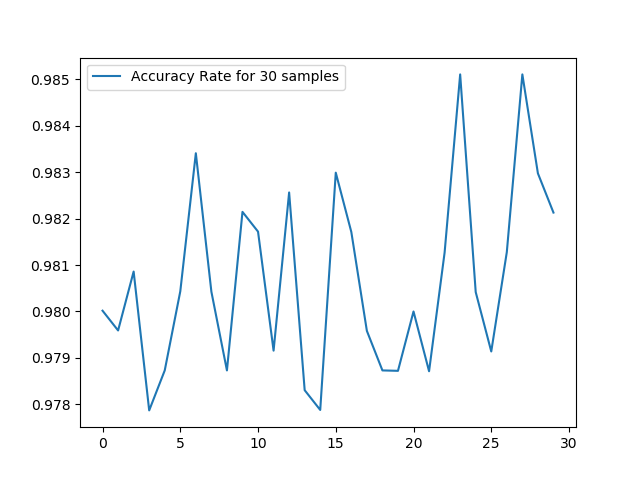

In [286]:
%matplotlib notebook
import matplotlib as plt    
import matplotlib.pyplot as plt

# Vẽ: 
plt.plot(Accuracy, label = "Accuracy Rate for 30 samples")
plt.legend()


Nếu giả sử rằng một hồ sơ GG tạo ra lãi 10% cho ngân hàng còn BG làm ngân hàng mất vốn hoàn toàn và mỗi một hồ sơ được duyệt vay đều được vay 1 USD thì các thống kê về lợi nhuận là: 


In [287]:
profit = GG*0.1 - BG
profit.describe()

count     30.000000
mean     172.123333
std        5.788257
min      158.400000
25%      168.375000
50%      173.500000
75%      175.300000
max      182.000000
dtype: float64

In [288]:
# Kết thúc sử dụng h2o: 
h2o.shutdown()

[WARNING] in <ipython-input-288-e73625e867d4> line 2:
    >>> h2o.shutdown()
        ^^^^ Deprecated, use ``h2o.cluster().shutdown()``.
H2O session _sid_b03a closed.


### Kết luận

So với mô hình GBM mặc định thì Accuracy của mô hình tinh chỉnh cao hơn (94.43% so với 91.45%) nhưng quan trọng hơn  là tỉ lệ xếp nhầm hồ sơ xấu thành hồ sơ tốt giảm từ 25% xuống còn 17.65%. 

Mặt khác sử dụng 30 mẫu khác nhau để kiểm định lại mô hình đã có thì tỉ lệ chính xác trung bình là 98.06% với độ lệch chuẩn rất bé 0.2%

